In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional, List
import scipy
import cython
import math, os, time
from tqdm.auto import tqdm
import pandas as pd
import glob
import seaborn as sns
pd.set_option('display.max_columns', None)

/home/mautie/temp/nostr/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from scipy.stats import rankdata

rankdata([10,1,1,1,1,1,0,100,90,90,70,20,10,10,])

array([ 8. ,  4. ,  4. ,  4. ,  4. ,  4. ,  1. , 14. , 12.5, 12.5, 11. ,
       10. ,  8. ,  8. ])

# Custom Extended Barabási-Albert graph
Output as directed graph.

In [13]:
def _random_subset(seq, m, rng):
    """Return m unique elements from seq.

    This differs from random.sample which can return repeated
    elements if seq holds repeated elements.

    Note: rng is a random.Random or numpy.random.RandomState instance.
    """
    targets = set()
    while len(targets) < m:
        x = rng.choice(seq)
        targets.add(x)
    return targets


def extended_barabasi_albert_digraph(n0:int, n:int, m:int, p:int, q:int, 
                                     seed: Optional[np.random.RandomState] = None):
    """
    Generate an extended Barabási–Albert graph with additional functionality.
    
    Parameters:
        n0 (int): Initial number of nodes.
        n (int): Total number of nodes in the graph.
        m (int): Number of edges to add for each operation.
        p (float): Probability of adding m new edges between existing nodes.
        q (float): Probability of rewiring m edges.
        seed (np.random.RandomState, optional): Random number generator.
    
    Returns:
        nx.DiGraph: The generated graph.
    """
    if seed is None:
        seed = np.random.RandomState()

    if not (n0 >= 1 and m >= 1 and m < n and n0 < n):
        raise ValueError("Invalid values for n0, n, or m.")
    if not (0 <= p + q < 1):
        raise ValueError("Probabilities p and q must satisfy p + q < 1.")
    
    # Start with n0 initial nodes
    G:nx.DiGraph = nx.DiGraph()
    attachment_preference: List[int] = list(range(n0))
    G.add_nodes_from(attachment_preference)

    # Complete the graph 
    while G.number_of_nodes() < n:
        action_prob = seed.random()

        # Adding m new edges between existing nodes
        if action_prob < p: 
            for _ in range(m):
                while True:
                    src_node = seed.randint(0, G.number_of_nodes())
                    dst_node = seed.choice(attachment_preference)
                    if src_node != dst_node and not G.has_edge(src_node, dst_node):
                        # add new edge and increase the corresponding pref. attachment
                        G.add_edge(src_node, dst_node)
                        attachment_preference.append(dst_node)
                        break

        # Rewiring m edges
        elif p <= action_prob < (p + q):
            if G.number_of_edges() > 0:
                for _ in range(m):
                    sd = list(G.edges())
                    while True:
                        src_node, dst_node = sd[ seed.randint(0, len(sd)) ]
                        new_dst_node = seed.choice(attachment_preference)
                        if new_dst_node not in [src_node, dst_node] and not G.has_edge(src_node, new_dst_node):
                            # Rewire and adjust the preferential attachment list
                            G.remove_edge(src_node, dst_node)
                            G.add_edge(src_node, new_dst_node)
                            attachment_preference.remove(dst_node)
                            attachment_preference.append(new_dst_node)
                            break

        # Adding new node with m edges
        else:
            # Select the edges' nodes by preferential attachment
            new_node = G.number_of_nodes()
            targets = _random_subset(attachment_preference, m, seed)
            # G.add_edges_from(zip([new_node] * m, targets))
            G.add_edges_from((new_node, target) for target in targets)
            # 1 new attachment to the target, (m+1) attachments to the new_node
            attachment_preference.extend(list(targets) + [new_node] * (m + 1))
    
    return G



Graph filename: data/graph_10_100_2_0.5_0.3.adjlist
Number of nodes in the graph: 100
Number of edges in the graph: 680
Average in-degree: 6.8
Average out-degree: 6.8
Density of the graph: 0.06868686868686869


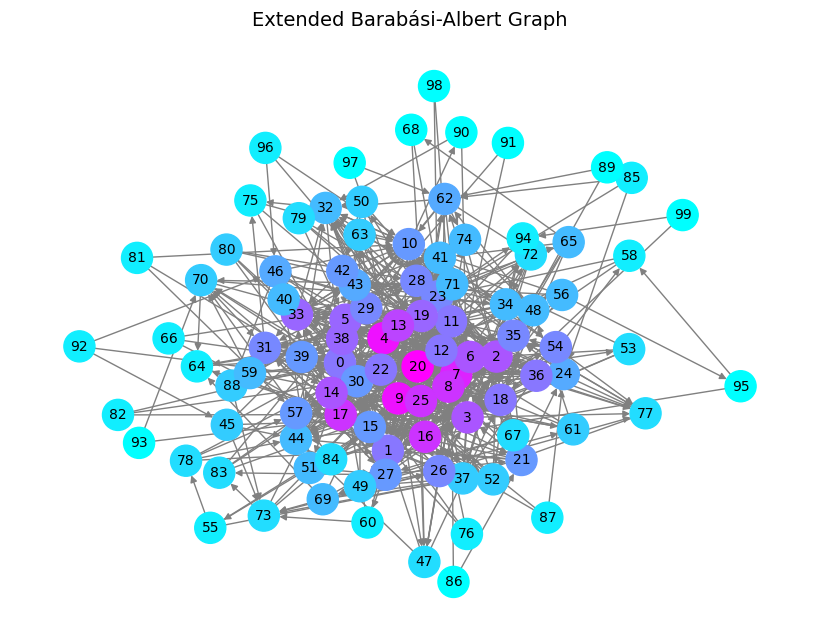

In [ ]:
random_state = np.random.RandomState(42)

# Net parameters
n0 = 10 # initial nodes
n = 100 # number of total nodes
m = 2   # number of edges to attach from a new node
p = 0.5 # probability of adding m new edges between existing nodes
q = 0.3 # probability of rewiring edges

# n0, n, m, p, q = 10, 200, 3, 0.3, 0.4
# n0, n, m, p, q = 10, 1000, 3, 0.3, 0.4

graph_fname = f'data/graph_{n0}_{n}_{m}_{p}_{q}.adjlist'
print('Graph filename:', graph_fname)

generate_graph = False
if generate_graph or not os.path.exists(graph_fname):
    start = time.time()
    # Generate the graph with the defined parameters
    graph = extended_barabasi_albert_digraph(n0, n, m, p, q, random_state)
    nx.write_adjlist(graph, graph_fname)
    print('Graph generation time:', time.time()-start)

graph = nx.read_adjlist(graph_fname, nodetype=int, create_using=nx.DiGraph)
# Basic statistics about the urn graph
print("Number of nodes in the graph:", graph.number_of_nodes())
print("Number of edges in the graph:", graph.number_of_edges())
print("Average in-degree:", np.mean([d for n, d in graph.in_degree()]))
print("Average out-degree:", np.mean([d for n, d in graph.out_degree()]))
print("Density of the graph:", nx.density(graph))

# Draw the graph using matplotlib
if graph.number_of_nodes() <= 100:
    plt.figure(figsize=(8, 6))
    # define the color of each node as its out-degree
    node_color = [d for n, d in graph.out_degree()]
    nx.draw(graph, with_labels=True,
            node_color=node_color, cmap='cool',
            edge_color='gray', node_size=500, font_size=10)
    plt.title("Extended Barabási-Albert Graph", fontsize=14)
    plt.show()

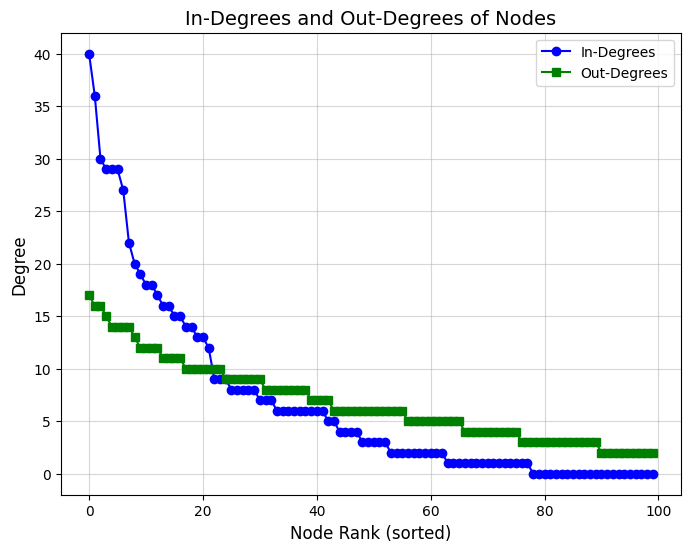

In [15]:
# Calculate in-degrees and out-degrees for all nodes
in_degrees = sorted([graph.in_degree(node) for node in graph.nodes()], reverse=True)
out_degrees = sorted([graph.out_degree(node) for node in graph.nodes()], reverse=True)

# Plot in-degrees and out-degrees
plt.figure(figsize=(8, 6))
plt.plot(in_degrees, label="In-Degrees", marker="o", color="blue")
plt.plot(out_degrees, label="Out-Degrees", marker="s", color="green")

plt.title("In-Degrees and Out-Degrees of Nodes", fontsize=14)
plt.xlabel("Node Rank (sorted)", fontsize=12)
plt.ylabel("Degree", fontsize=12)
plt.legend()
plt.grid(alpha=0.5)
plt.show()


In [16]:
# graph.edges()

# FreeNet Web-of-Trust scores

In [17]:
def compute_wot_rank(trust_graph, truster, trustee):
    """
    Compute the rank (shortest path distance for positive edges only) from truster to trustee.
    """
    try:
        # Compute shortest path length
        rank = nx.shortest_path_length(trust_graph, source=truster, target=trustee)#, weight='weight')
    except nx.NetworkXNoPath:
        rank = -1 #float('inf')  # No path found
    return rank

RANK_TO_CAPACITY = [100, 40, 16, 6, 2, 1]
def compute_wot_capacity(rank):
    """
    Compute the capacity based on the rank using the defined exponential decay formula.
    """
    if rank < 0:
        return 0
    # elif rank >= 100:
    #     return 0 # infinite
    elif rank > 5:
        return 1
    else:
        return RANK_TO_CAPACITY[rank]

def compute_wot_score(trust_graph, truster, trustee, verbose=False):
    """
    Compute the score of trustee from the perspective of truster.
    """
    if truster==trustee:
        return 100
    if trust_graph.has_edge(truster, trustee):
        # Direct trust value exists
        # return 100 #trust_graph[truster][trustee]['weight']
        return trust_graph.get_edge_data(truster,trustee).get('weight', 100)
    
    # Indirect computation
    score = 0
    neighbor_of_trustee = trust_graph.in_edges(trustee)
    for neighbor, _ in neighbor_of_trustee:
        trust_value = 100 #trust_graph[neighbor][trustee]['weight']
        rank = compute_wot_rank(trust_graph, truster, neighbor)
        capacity = compute_wot_capacity(rank)
        score += (trust_value * capacity) // 100

        if verbose:
            if rank >= 0:
                print(f'  {truster}--...-->{neighbor}->{trustee}: rank={rank} capacity={capacity}')
            else:
                print(f'  {truster} NOPATH {neighbor}->{trustee}: rank={rank} capacity={capacity}')

    # if score != 0:
    #     score = round(score / len(neighbor_of_trustee))    
    return score

def compute_wot_score_rev(trust_graph, truster, trustee, verbose=False):
    """
    Compute the score of trustee from the perspective of truster.
    """
    if truster==trustee:
        return 100
    if trust_graph.has_edge(truster, trustee):
        # Direct trust value exists
        # return 100 #trust_graph[truster][trustee]['weight']
        return trust_graph.get_edge_data(truster,trustee).get('weight', 100)
    
    # Indirect computation
    score = 0
    outgoing_of_truster = trust_graph.out_edges(truster)
    for _, followed in outgoing_of_truster:
        trust_value = 100 #trust_graph[truster][followed]['weight']
        rank = compute_wot_rank(trust_graph, followed, trustee)
        capacity = compute_wot_capacity(rank)
        score += (trust_value * capacity) // 100

        if verbose:
            if rank >= 0:
                print(f'  {truster}->{followed}--...-->{trustee}: rank={rank} capacity={capacity}')
            else:
                print(f'  {truster}->{followed} NOPATH {trustee}: rank={rank} capacity={capacity}')


    # if score != 0:
    #     score = round(score / len(outgoing_of_truster))
    return score

In [18]:
nnz_scores, nnz_rev_scores = 0, 0
# compute and print the scores of each pair of nodes
for truster in graph.nodes():
    for trustee in graph.nodes():
        score = compute_wot_score(graph, truster, trustee)
        rev_score = compute_wot_score_rev(graph, truster, trustee)
        if score != 0 or rev_score != 0:
            print(f'{truster} -> {trustee}: {score} | {rev_score}')
            nnz_scores += 1 if score != 0 else 0
            nnz_rev_scores += 1 if rev_score != 0 else 0

print(f"Number of non-zero scores: {nnz_scores} | {nnz_rev_scores}")

0 -> 0: 100 | 100
0 -> 7: 100 | 100
0 -> 5: 100 | 100
0 -> 1: 100 | 100
0 -> 9: 100 | 100
0 -> 23: 100 | 100
0 -> 20: 100 | 100
0 -> 18: 100 | 100
0 -> 3: 100 | 100
0 -> 46: 100 | 100
0 -> 2: 100 | 100
0 -> 31: 158 | 164
0 -> 15: 362 | 280
0 -> 37: 208 | 222
0 -> 30: 284 | 256
0 -> 8: 176 | 178
0 -> 11: 455 | 280
0 -> 19: 245 | 232
0 -> 29: 80 | 188
0 -> 10: 478 | 304
0 -> 27: 142 | 174
0 -> 34: 110 | 154
0 -> 62: 112 | 208
0 -> 77: 144 | 198
0 -> 25: 84 | 184
0 -> 16: 302 | 256
0 -> 39: 166 | 198
0 -> 44: 145 | 188
0 -> 17: 174 | 232
0 -> 48: 150 | 198
0 -> 4: 16 | 54
0 -> 6: 232 | 208
0 -> 12: 258 | 198
0 -> 32: 178 | 150
0 -> 24: 174 | 164
0 -> 33: 194 | 208
0 -> 56: 22 | 66
0 -> 64: 38 | 100
0 -> 14: 196 | 184
0 -> 28: 128 | 188
0 -> 41: 90 | 178
0 -> 54: 62 | 144
0 -> 21: 144 | 198
0 -> 26: 104 | 174
0 -> 53: 40 | 144
0 -> 72: 112 | 198
0 -> 47: 152 | 222
0 -> 38: 88 | 174
0 -> 13: 120 | 174
0 -> 22: 73 | 164
0 -> 61: 46 | 144
0 -> 57: 111 | 154
0 -> 70: 62 | 154
0 -> 90: 16 | 120

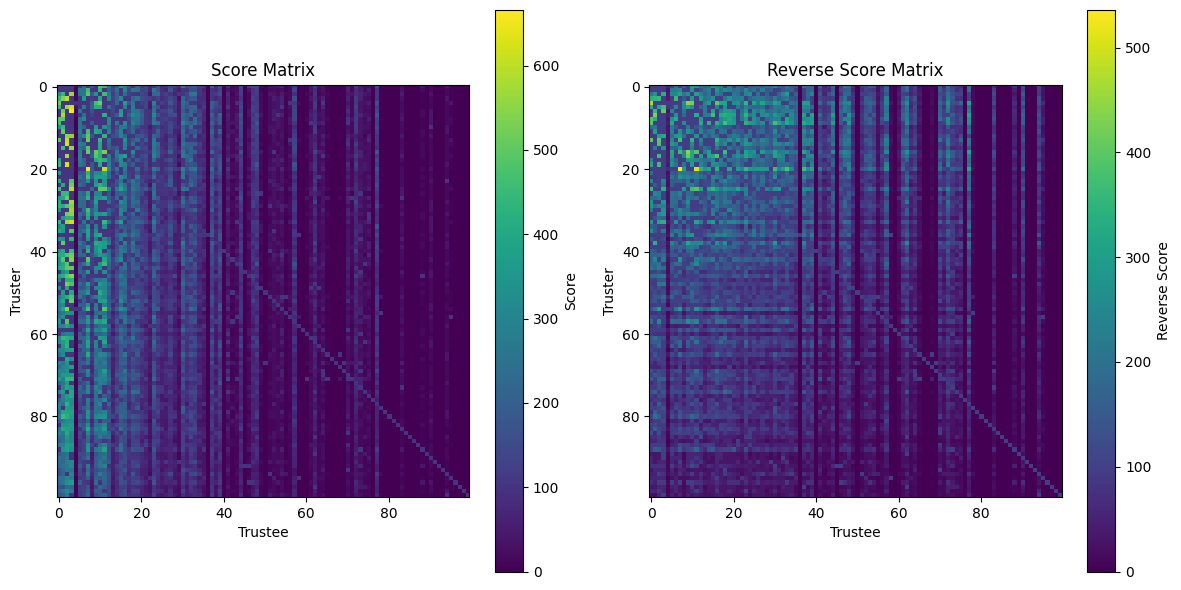

In [19]:
# Initialize matrices to store scores
num_nodes = graph.number_of_nodes()
score_matrix = np.zeros((num_nodes, num_nodes), dtype=int)
rev_score_matrix = np.zeros((num_nodes, num_nodes), dtype=int)

# Compute and store the scores in matrices
for truster in graph.nodes():
    for trustee in graph.nodes():
        score = compute_wot_score(graph, truster, trustee)
        rev_score = compute_wot_score_rev(graph, truster, trustee)
        score_matrix[truster, trustee] = score
        rev_score_matrix[truster, trustee] = rev_score

# Plot the matrices as heatmaps
plt.figure(figsize=(12, 6))

# Plot score matrix
plt.subplot(1, 2, 1)
plt.imshow(score_matrix, cmap='viridis', aspect='equal')
plt.colorbar(label='Score')
plt.title('Score Matrix')
plt.xlabel('Trustee')
plt.ylabel('Truster')

# Plot reverse score matrix
plt.subplot(1, 2, 2)
plt.imshow(rev_score_matrix, cmap='viridis', aspect='equal')
plt.colorbar(label='Reverse Score')
plt.title('Reverse Score Matrix')
plt.xlabel('Trustee')
plt.ylabel('Truster')

plt.tight_layout()
plt.show()

# Hypothesis: The scores generate similar rankings for the nodes (for each user)

Average Spearman correlation 0.8414


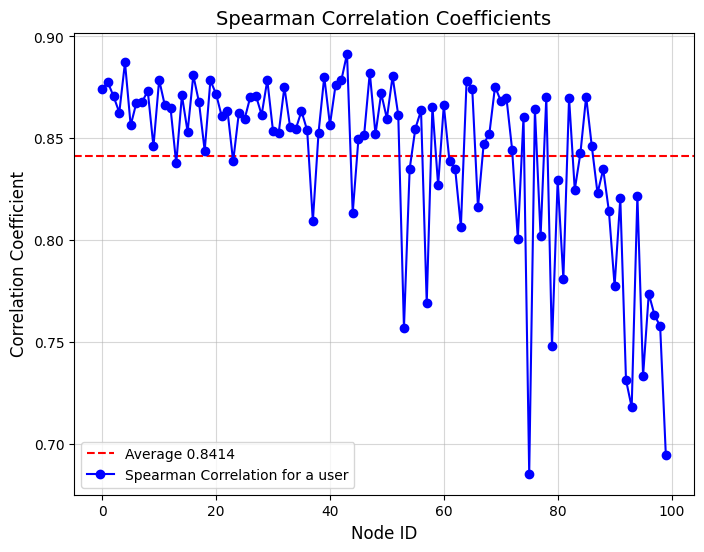

In [20]:
def compare_score_ranks(graph, truster):
    # compute all scores and rev_scores, and compare the ranks using the Spearman correlation coefficient
    scores = []
    rev_scores = []
    for trustee in graph.nodes():
        score = compute_wot_score(graph, truster, trustee)
        rev_score = compute_wot_score_rev(graph, truster, trustee)
        scores.append(score)
        rev_scores.append(rev_score)

    # Compute the Spearman correlation
    rho = np.corrcoef(scores, rev_scores)[0, 1]
    return rho

# Compute the Spearman correlation for all nodes
correlations = []
for truster in graph.nodes():
    rho = compare_score_ranks(graph, truster)
    correlations.append(rho)

# Compute the average Spearman correlation
avg_rho = np.mean(correlations)
print(f"Average Spearman correlation {avg_rho:.4f}")

# Plot the Spearman correlation coefficients
plt.figure(figsize=(8, 6))
plt.axhline(y=avg_rho, color='r', linestyle='--', label=f'Average {avg_rho:.4f}')
plt.plot(correlations, marker="o", color="blue", label="Spearman Correlation for a user")
plt.title("Spearman Correlation Coefficients", fontsize=14)
plt.xlabel("Node ID", fontsize=12)
plt.ylabel("Correlation Coefficient", fontsize=12)
plt.grid(alpha=0.5)
plt.legend()
plt.show()

# Count non-overlapping paths as trust scores

In [21]:
def compute_wot_score_indep(trust_graph, truster, trustee, verbose=False):
    """
    Compute the score of trustee from the perspective of truster.
    """
    if truster==trustee:
        return 100
    if trust_graph.has_edge(truster, trustee):
        # Direct trust value exists
        # return 100 #trust_graph[truster][trustee]['weight']
        return trust_graph.get_edge_data(truster,trustee).get('weight', 100)
    
    cut_value, partition = nx.minimum_cut(trust_graph, truster, trustee)
    # print(cut_value, partition)
    partA, partB = partition
    partA, partB = set(partA), set(partB)
    truster_is_a = (truster in partA)
    edge_cut = []
    for s,t in trust_graph.edges():
        if s in partA and t in partB and truster_is_a:
            edge_cut.append((s,t))
            # edge_cut.append((s,t) if truster_is_a else (t,s))
        if s in partB and t in partA and not truster_is_a:
            edge_cut.append((t,s))
            # edge_cut.append((t,s) if truster_is_a else (s,t))

    # print(edge_cut)
    assert len(edge_cut) == int(cut_value)

    # truster -> nodeA -> nodeB -> trustee
    score = 0
    for nodeA, nodeB in edge_cut:
        d1 = nx.shortest_path_length(trust_graph, source=truster, target=nodeA)
        d2 = nx.shortest_path_length(trust_graph, source=nodeB, target=trustee)
        rank = d1 + d2
        # print(truster, nodeA, nodeB, trustee, rank)
        capacity = compute_wot_capacity(rank)
        score += capacity

    return score




cap_graph = graph.copy()
nx.set_edge_attributes(cap_graph, 1.0, "capacity")
# cap_graph.edges[65, 68]
# for edge in cap_graph.edges():

# for truster in tqdm(graph.nodes()):
#     for trustee in graph.nodes():
#         print(truster, trustee, compute_wot_score_indep(cap_graph, truster, trustee))


# print(compute_wot_score_indep(cap_graph, 0, 26))

In [22]:
# nx.shortest_path_length(cap_graph, source=50, target=26)
nx.shortest_path_length(cap_graph, source=50, target=0)
nx.shortest_path_length(cap_graph, source=67, target=26)
nx.shortest_path_length(cap_graph, source=67, target=50)


1

# Personalized Page Rank (Twitter)

In [23]:
rng = random_state  # Use the existing random_state variable

def required_length(topK: int, alpha: float) -> int:
    """
    The function required_length() returns the length that the personalized walk
    has to reach for the Personalized Pagerank to achieve the specified precision.
    """
    a = float(alpha)
    c = 100.0
    N = 10000000.0  # Upper bound for the size of the graph.

    res = c / (1 - a) * math.pow(float(topK), a) * math.pow(N, 1 - a)
    return round(res)


def personalized_random_walk(graph, rng, source_node, max_steps, alpha=0.85):
    """
    Perform a personalized random walk on the graph starting from a specific source node.

    Parameters:
        graph (nx.DiGraph): The input graph.
        source_node (int): The starting/teleporting node for the personalized random walk.
        max_steps (int): The maximum number of steps for the random walk.
        alpha (float): Dampening factor / teleport probability (default is 0.85).

    Returns:
        List[float]: The stationary distribution of the random walk.
    """
    # Initialize the probability distribution
    num_nodes = graph.number_of_nodes()
    prob = np.zeros(num_nodes)
    # prob[source_node] = 1  # Start from the source node

    node = source_node
    # Perform the random walk
    for _ in range(max_steps):
        if rng.random() > alpha:
            node = source_node # reset

        # pick a random successor node from graph.node
        successors = list(graph.successors(node))
        if successors:
            node = rng.choice(successors)
            prob[node] += 1
        else:
            node = source_node  # Reset if no successors

    # normalize
    sum = np.sum(prob)
    if sum > 0:
        prob /= sum

    return prob

req_length = required_length(5, 0.85)
print('required_length', req_length)
ppr_distrib = personalized_random_walk(graph, random_state, 3, req_length)
print(ppr_distrib)

required_length 29379
[3.65567242e-02 3.69311413e-02 5.03420811e-02 4.60192655e-02
 4.08455019e-04 2.90343443e-02 2.68218796e-02 4.74488580e-02
 1.17090439e-02 4.15262603e-02 3.30848565e-02 4.91507539e-02
 2.10694714e-02 7.38622826e-03 1.43640015e-02 2.31457844e-02
 4.20027911e-02 2.59709316e-02 2.01164097e-02 1.83804759e-02
 1.34790156e-02 9.80292045e-03 8.37332789e-03 4.26835495e-02
 8.23717621e-03 9.83695837e-03 7.01181116e-03 1.27982573e-02
 6.70546989e-03 4.49300521e-03 1.99121822e-02 8.13506246e-03
 1.27642193e-02 1.36151673e-02 9.12216209e-03 6.70546989e-03
 0.00000000e+00 3.27444773e-02 7.45430409e-03 3.20977569e-02
 0.00000000e+00 4.08455019e-03 9.87099629e-04 1.94016134e-03
 2.21246469e-02 0.00000000e+00 2.58688179e-03 6.39912863e-03
 2.29075190e-02 5.10568774e-04 0.00000000e+00 1.70189591e-03
 3.02937472e-03 2.31457844e-03 3.16552640e-03 3.74417101e-04
 3.74417101e-04 9.02004833e-03 6.80758365e-05 0.00000000e+00
 6.80758365e-05 2.00823718e-03 8.37332789e-03 8.84985874e-04
 1

In [24]:
# generate a lot of random walks to get a stable statistics
samples = [personalized_random_walk(graph, random_state, 3, req_length) for k in tqdm(range(graph.number_of_nodes()))]
samples = np.array(samples)

 26%|██▌       | 26/100 [00:10<00:30,  2.41it/s]


KeyboardInterrupt: 

In [ ]:
means = np.mean(samples, axis=0)
# print(means)
order = list(reversed(np.argsort(means)))
plt.boxplot(samples[:, order])
plt.show()

In [ ]:
def dual_personalized_pagerank(graph, reversed_graph, rng, source_node, target_node, max_steps, alpha=0.85):
    """
    Compute a Dual Personalized PageRank (PPR) distribution between two nodes in a directed graph.

    This function simulates a symmetric relevance score between a source node and a target node
    by performing two separate random walks:
        1. A forward random walk starting from the source_node on the original graph.
        2. A backward random walk starting from the target_node on the reversed graph 
           (i.e., walking "backwards" through the original edges).

    Each walk produces a probability distribution over nodes representing visit frequencies.
    The intersection of these walks — representing mutual relevance — is computed via the 
    element-wise product of the two distributions.

    The final distribution highlights nodes that are likely to be visited by both walks,
    approximating a meeting point between the forward and backward paths. This is useful
    in tasks such as link prediction, semantic proximity, or candidate matching in
    personalized recommendation settings.

    Parameters:
        graph (nx.DiGraph): The original directed graph.
        rng (np.random.Generator): A NumPy random number generator for reproducibility.
        source_node (int): The source node to initiate the forward walk.
        target_node (int): The target node to initiate the backward walk.
        max_steps (int): the required number of steps.
        alpha (float): Teleport probability (default 0.85).

    Returns:
        float: the dual relevance.
    """
    # Forward walk from source_node
    forward_distribution = personalized_random_walk(graph, rng, source_node, max_steps, alpha)

    # Backward walk from target_node using the reversed graph
    backward_distribution = personalized_random_walk(reversed_graph, rng, target_node, max_steps, alpha)

    # Element-wise product (Hadamard product) to find intersection strength
    dual_ppr = forward_distribution * backward_distribution

    return np.sum(dual_ppr)

# Esempio d'uso
req_length = required_length(2.5, 0.85)
print('required_length', req_length)

reversed_graph = graph.reverse(copy=True)
dual_ppr_score = dual_personalized_pagerank(graph, reversed_graph, rng, source_node=3, target_node=7, max_steps=req_length, alpha=0.85)
print(f'score:', dual_ppr_score)
# top_indices = np.argsort(dual_ppr_vector)[::-1][:10]  # top 10 nodi più rilevanti
# print("Top 10 dual PPR nodes:", top_indices)

dual_distrib = np.array([dual_personalized_pagerank(graph, reversed_graph, rng, source_node=3, target_node=i, max_steps=req_length, alpha=0.85) 
                         for i in tqdm(range(graph.number_of_nodes()))])

In [ ]:
print(dual_distrib)

In [ ]:
nodes = np.arange(len(ppr_distrib))  # node IDs or indices

bar_width = 0.4

plt.figure(figsize=(10, 6))
plt.bar(nodes - bar_width/2, ppr_distrib, width=bar_width, label='PPR')
plt.bar(nodes + bar_width/2, dual_distrib, width=bar_width, label='Dual PPR')

plt.xlabel("Node ID")
plt.ylabel("Score")
plt.title("Comparison of Two Node Score Distributions")
plt.legend()
plt.grid(True)
plt.show()

# Sampling procedure

In [26]:
def get_distance_in_graph(trust_graph, truster, trustee):
    try:
        dist = nx.shortest_path_length(trust_graph, source=truster, target=trustee)
    except nx.NetworkXNoPath:
        dist = -1 #float('inf')  # No path found
    return dist

In [27]:
graph = nx.read_adjlist(graph_fname, nodetype=int, create_using=nx.DiGraph)
nx.set_edge_attributes(graph, 1.0, "capacity")

# n_bots = 100
# N = graph_pre.number_of_nodes()
# bots_id_start = graph_pre.number_of_nodes()
# for i in range(n_bots):
#     graph_pre.add_node(i+bots_id_start)
# bots_id_end = graph_pre.number_of_nodes()

# print(bots_id_start, bots_id_end)

In [28]:
def sample_datarow(graph, n_bots):
    graph_pre = graph.copy()

    N = graph_pre.number_of_nodes()
    bots_id_start = graph_pre.number_of_nodes()
    for i in range(n_bots):
        graph_pre.add_node(i+bots_id_start)
    bots_id_end = graph_pre.number_of_nodes()
    # print(bots_id_start, bots_id_end)

    # select the actors
    user_ids = list(range(N))
    victim = np.random.choice(user_ids)
    user_ids.remove(victim)
    relayer = np.random.choice(user_ids)
    user_ids.remove(relayer)
    villain = np.random.choice(user_ids)
    user_ids.remove(villain)

    # print(victim, relayer, villain)

    graph_post = graph_pre.copy()
    # relayer -> villain
    graph_post.add_edge(relayer, villain, capacity=1.0)
    for bot in range(bots_id_start, bots_id_end):
        # relayer -> bots
        graph_post.add_edge(relayer, bot, capacity=1.0)
        # bots -> villain
        graph_post.add_edge(bot, villain, capacity=1.0)

    # Compute Freenet WoT scores
    FreeNet_pre_scores_freenet = [compute_wot_score(graph_pre, victim, trustee) for trustee in range(N)]
    FreeNet_pre_ranks_freenet = rankdata(FreeNet_pre_scores_freenet)

    FreeNet_post_scores_freenet = [compute_wot_score(graph_post, victim, trustee) for trustee in range(N)]
    FreeNet_post_ranks_freenet = rankdata(FreeNet_post_scores_freenet)

    # Compute Reversed freenet WoT scores
    Reversed_pre_scores_freenet = [compute_wot_score_rev(graph_pre, victim, trustee) for trustee in range(N)]
    Reversed_pre_ranks_freenet = rankdata(Reversed_pre_scores_freenet)

    Reversed_post_scores_freenet = [compute_wot_score_rev(graph_post, victim, trustee) for trustee in range(N)]
    Reversed_post_ranks_freenet = rankdata(Reversed_post_scores_freenet)

    # Compute Independent freenet WoT scores
    Independent_pre_scores_freenet = [compute_wot_score_indep(graph_pre, victim, trustee) for trustee in range(N)]
    Independent_pre_ranks_freenet = rankdata(Independent_pre_scores_freenet)

    Independent_post_scores_freenet = [compute_wot_score_indep(graph_post, victim, trustee) for trustee in range(N)]
    Independent_post_ranks_freenet = rankdata(Independent_post_scores_freenet)

    datarow = {
        'FreeNet_pre_score': FreeNet_pre_scores_freenet[villain],
        'FreeNet_post_score': FreeNet_post_scores_freenet[villain],
        'FreeNet_pre_rank': FreeNet_pre_ranks_freenet[villain],
        'FreeNet_post_rank': FreeNet_post_ranks_freenet[villain],
        'FreeNet_delta_ranks': FreeNet_post_ranks_freenet[villain] - FreeNet_pre_ranks_freenet[villain],
        'Reversed_pre_score': Reversed_pre_scores_freenet[villain],
        'Reversed_post_score': Reversed_post_scores_freenet[villain],
        'Reversed_pre_rank': Reversed_pre_ranks_freenet[villain],
        'Reversed_post_rank': Reversed_post_ranks_freenet[villain],
        'Reversed_delta_ranks': Reversed_post_ranks_freenet[villain] - Reversed_pre_ranks_freenet[villain],
        'Independent_pre_score': Independent_pre_scores_freenet[villain],
        'Independent_post_score': Independent_post_scores_freenet[villain],
        'Independent_pre_rank': Independent_pre_ranks_freenet[villain],
        'Independent_post_rank': Independent_post_ranks_freenet[villain],
        'Independent_delta_ranks': Independent_post_ranks_freenet[villain] - Independent_pre_ranks_freenet[villain],
        'dist_victim_relayer': get_distance_in_graph(graph_pre, victim, relayer),
        'out_deg_victim': graph_pre.out_degree(victim),
        'in_deg_villain': graph_pre.in_degree(villain),
        'victim':victim,
        'villain':villain,
        'relayer':relayer,
    }

    return datarow

In [29]:
datarow = sample_datarow(graph, n_bots=100)
print(datarow)


{'FreeNet_pre_score': 88, 'FreeNet_post_score': 704, 'FreeNet_pre_rank': np.float64(61.0), 'FreeNet_post_rank': np.float64(100.0), 'FreeNet_delta_ranks': np.float64(39.0), 'Reversed_pre_score': 104, 'Reversed_post_score': 104, 'Reversed_pre_rank': np.float64(80.5), 'Reversed_post_rank': np.float64(80.5), 'Reversed_delta_ranks': np.float64(0.0), 'Independent_pre_score': 88, 'Independent_post_score': 104, 'Independent_pre_rank': np.float64(68.0), 'Independent_post_rank': np.float64(83.5), 'Independent_delta_ranks': np.float64(15.5), 'dist_victim_relayer': 2, 'out_deg_victim': 5, 'in_deg_villain': 4, 'victim': np.int64(52), 'villain': np.int64(72), 'relayer': np.int64(54)}


In [31]:
num_rows = 100
data = [sample_datarow(graph, n_bots=100) for _ in range(num_rows)]
data = pd.DataFrame(data)
data.head(5)
data.to_csv("data/computation.csv")

-1         Axes(0.1,0.679412;0.235294x0.220588)
 1    Axes(0.382353,0.679412;0.235294x0.220588)
 2    Axes(0.664706,0.679412;0.235294x0.220588)
 3         Axes(0.1,0.414706;0.235294x0.220588)
 4    Axes(0.382353,0.414706;0.235294x0.220588)
 5    Axes(0.664706,0.414706;0.235294x0.220588)
 6             Axes(0.1,0.15;0.235294x0.220588)
 7        Axes(0.382353,0.15;0.235294x0.220588)
dtype: object

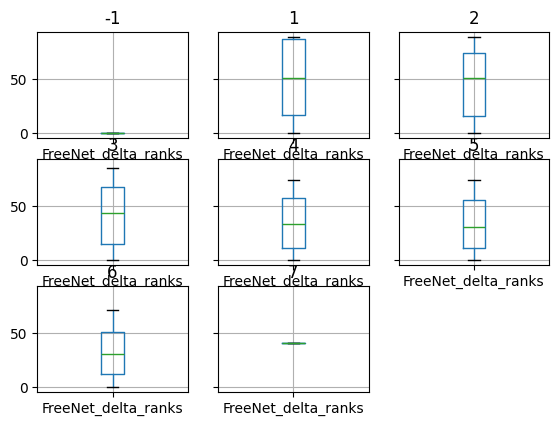

In [50]:
data.groupby('dist_victim_relayer').boxplot(column='FreeNet_delta_ranks')

<Axes: >

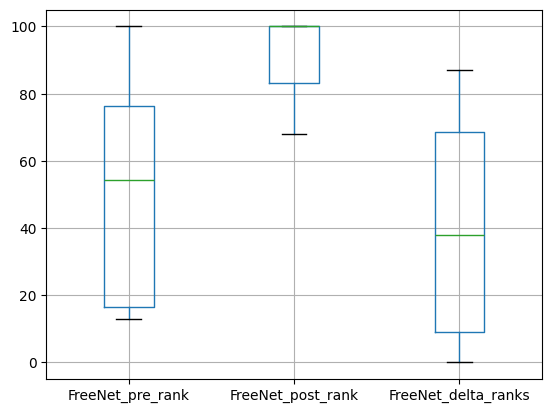

In [57]:
data[(data.dist_victim_relayer>=0) & (data.victim==22)].boxplot(column=['FreeNet_pre_rank', 'FreeNet_post_rank', 'FreeNet_delta_ranks'])

-1         Axes(0.1,0.679412;0.235294x0.220588)
 1    Axes(0.382353,0.679412;0.235294x0.220588)
 2    Axes(0.664706,0.679412;0.235294x0.220588)
 3         Axes(0.1,0.414706;0.235294x0.220588)
 4    Axes(0.382353,0.414706;0.235294x0.220588)
 5    Axes(0.664706,0.414706;0.235294x0.220588)
 6             Axes(0.1,0.15;0.235294x0.220588)
 7        Axes(0.382353,0.15;0.235294x0.220588)
dtype: object

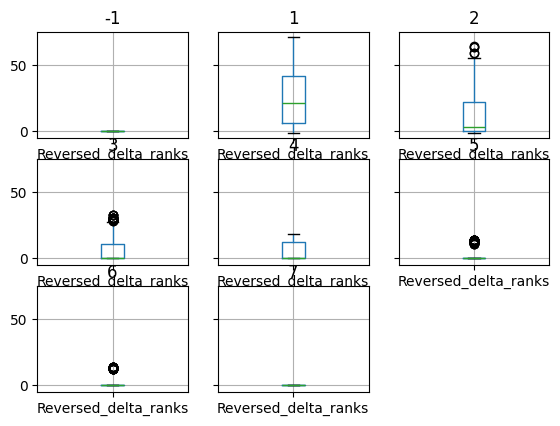

In [49]:
data.groupby('dist_victim_relayer').boxplot(column='Reversed_delta_ranks')

<Axes: >

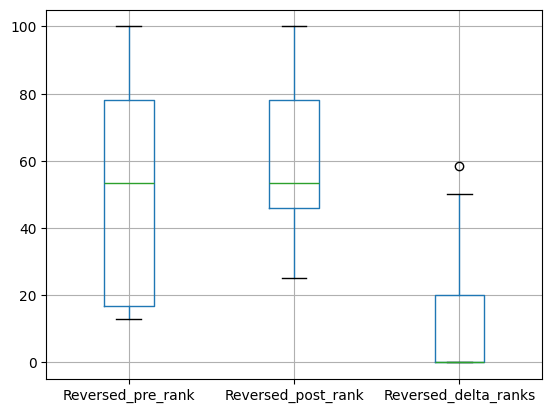

In [71]:
data[(data.dist_victim_relayer>=0) & (data.victim==22)].boxplot(column=['Reversed_pre_rank', 'Reversed_post_rank', 'Reversed_delta_ranks'])

-1         Axes(0.1,0.679412;0.235294x0.220588)
 1    Axes(0.382353,0.679412;0.235294x0.220588)
 2    Axes(0.664706,0.679412;0.235294x0.220588)
 3         Axes(0.1,0.414706;0.235294x0.220588)
 4    Axes(0.382353,0.414706;0.235294x0.220588)
 5    Axes(0.664706,0.414706;0.235294x0.220588)
 6             Axes(0.1,0.15;0.235294x0.220588)
 7        Axes(0.382353,0.15;0.235294x0.220588)
dtype: object

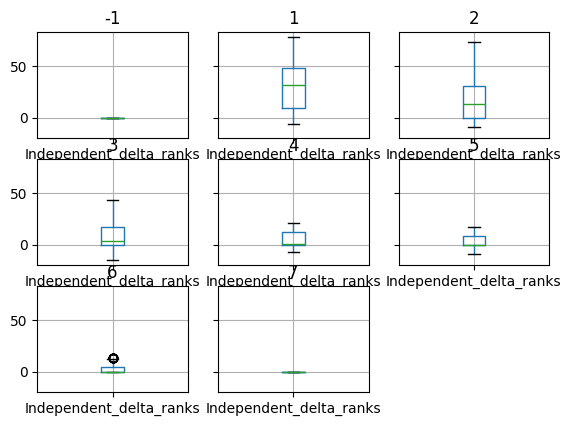

In [47]:
data.groupby('dist_victim_relayer').boxplot(column='Independent_delta_ranks')

<Axes: >

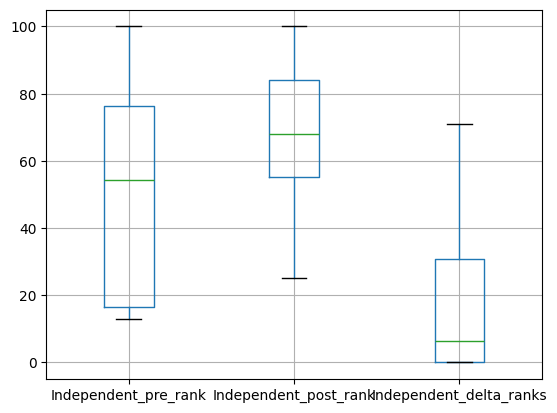

In [72]:
data[(data.dist_victim_relayer>=0) & (data.victim==22)].boxplot(column=['Independent_pre_rank', 'Independent_post_rank', 'Independent_delta_ranks'])

In [3]:
data = []
for file in glob.glob("data/computation*.csv"):
  print(file)
  data.append(pd.read_csv(file, delimiter=',', ))
data = pd.concat(data)
data = data.reset_index(drop=True)

display(data.head(5))

data/computation9.csv
data/computation5.csv
data/computation4.csv
data/computation2.csv
data/computation0.csv
data/computation1.csv
data/computation7.csv
data/computation8.csv
data/computation.csv
data/computation6.csv
data/computation3.csv


,Unnamed: 0,FreeNet_pre_score,FreeNet_post_score,FreeNet_pre_rank,FreeNet_post_rank,FreeNet_delta_ranks,Reversed_pre_score,Reversed_post_score,Reversed_pre_rank,Reversed_post_rank,Reversed_delta_ranks,Independent_pre_score,Independent_post_score,Independent_pre_rank,Independent_post_rank,Independent_delta_ranks,Random_pre_score,Random_post_score,Random_pre_rank,Random_post_rank,Random_delta_ranks,dist_victim_relayer,out_deg_victim,in_deg_villain,victim,villain,relayer
0,0,214,420,91.0,98.0,7.0,192,192,92.0,92.0,0.0,192,192,92.0,92.0,0.0,0.024133,0.026141,187.0,189.0,2.0,3,9,17,26,6,70
1,1,32,648,50.0,100.0,50.0,38,48,56.0,71.0,15.0,32,48,50.0,73.5,23.5,0.004459,0.020457,152.0,186.0,34.0,2,3,3,96,29,5
2,2,6,108,32.0,76.0,44.0,15,15,28.0,28.0,0.0,6,8,32.0,34.0,2.0,0.000068,0.000102,129.0,129.5,0.5,4,9,2,54,58,65
3,3,14,630,34.0,100.0,66.0,56,90,35.0,45.5,10.5,14,90,34.0,62.0,28.0,0.001362,0.013139,141.0,177.0,36.0,2,10,3,36,43,39
4,4,22,638,44.0,100.0,56.0,34,44,43.5,51.0,7.5,22,40,44.0,52.0,8.0,0.001293,0.004357,140.0,152.0,12.0,2,4,3,53,51,52


-1         Axes(0.1,0.679412;0.235294x0.220588)
 1    Axes(0.382353,0.679412;0.235294x0.220588)
 2    Axes(0.664706,0.679412;0.235294x0.220588)
 3         Axes(0.1,0.414706;0.235294x0.220588)
 4    Axes(0.382353,0.414706;0.235294x0.220588)
 5    Axes(0.664706,0.414706;0.235294x0.220588)
 6             Axes(0.1,0.15;0.235294x0.220588)
 7        Axes(0.382353,0.15;0.235294x0.220588)
dtype: object

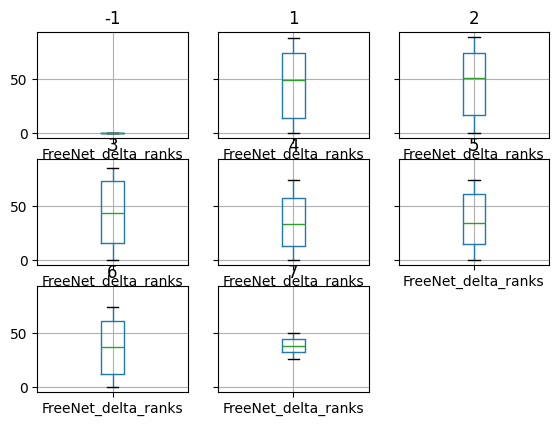

In [4]:
data.groupby('dist_victim_relayer').boxplot(column='FreeNet_delta_ranks')

-1         Axes(0.1,0.679412;0.235294x0.220588)
 1    Axes(0.382353,0.679412;0.235294x0.220588)
 2    Axes(0.664706,0.679412;0.235294x0.220588)
 3         Axes(0.1,0.414706;0.235294x0.220588)
 4    Axes(0.382353,0.414706;0.235294x0.220588)
 5    Axes(0.664706,0.414706;0.235294x0.220588)
 6             Axes(0.1,0.15;0.235294x0.220588)
 7        Axes(0.382353,0.15;0.235294x0.220588)
dtype: object

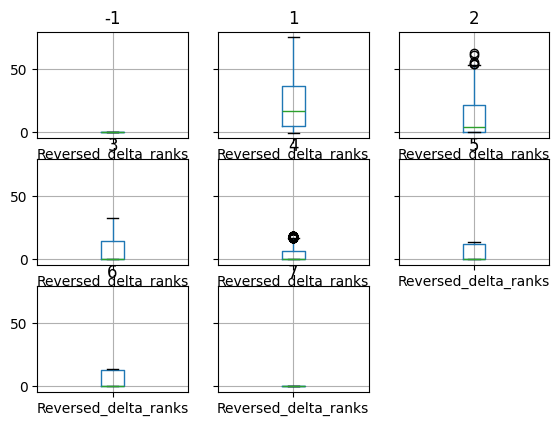

In [5]:
data.groupby('dist_victim_relayer').boxplot(column='Reversed_delta_ranks')

-1         Axes(0.1,0.679412;0.235294x0.220588)
 1    Axes(0.382353,0.679412;0.235294x0.220588)
 2    Axes(0.664706,0.679412;0.235294x0.220588)
 3         Axes(0.1,0.414706;0.235294x0.220588)
 4    Axes(0.382353,0.414706;0.235294x0.220588)
 5    Axes(0.664706,0.414706;0.235294x0.220588)
 6             Axes(0.1,0.15;0.235294x0.220588)
 7        Axes(0.382353,0.15;0.235294x0.220588)
dtype: object

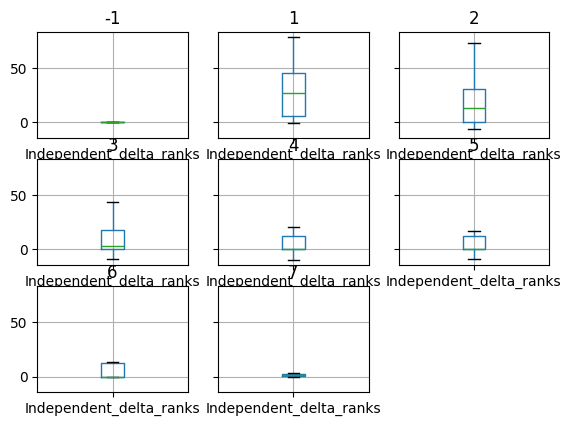

In [6]:
data.groupby('dist_victim_relayer').boxplot(column='Independent_delta_ranks')

dist_victim_relayer
-1    [[Axes(0.125,0.11;0.775x0.77)]]
 1    [[Axes(0.125,0.11;0.775x0.77)]]
 2    [[Axes(0.125,0.11;0.775x0.77)]]
 3    [[Axes(0.125,0.11;0.775x0.77)]]
 4    [[Axes(0.125,0.11;0.775x0.77)]]
 5    [[Axes(0.125,0.11;0.775x0.77)]]
 6    [[Axes(0.125,0.11;0.775x0.77)]]
 7    [[Axes(0.125,0.11;0.775x0.77)]]
dtype: object

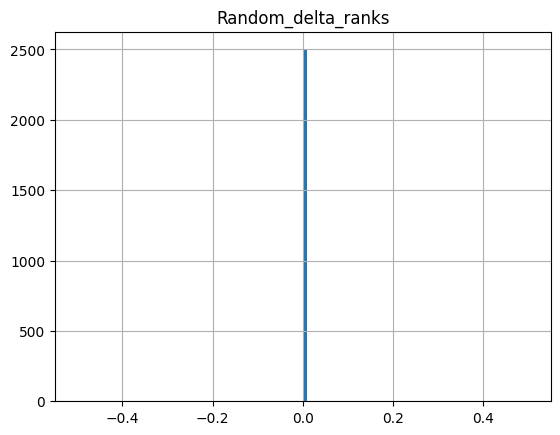

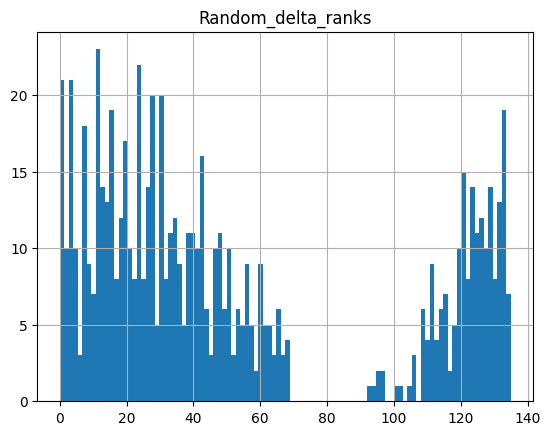

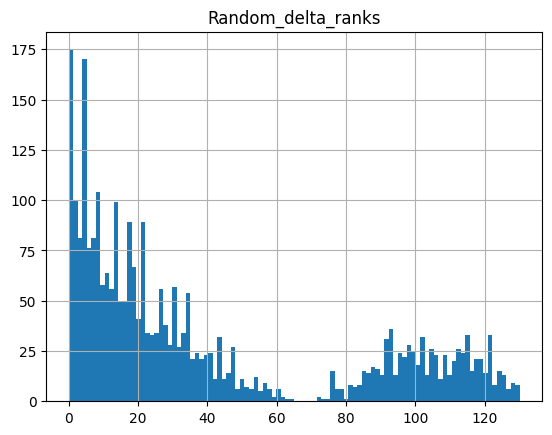

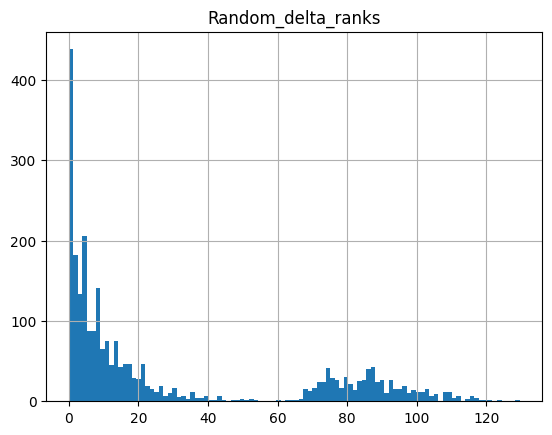

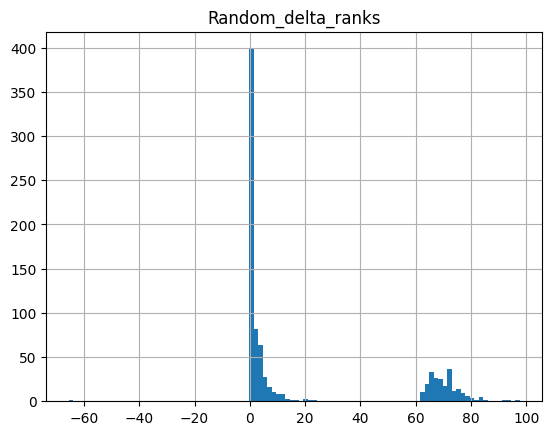

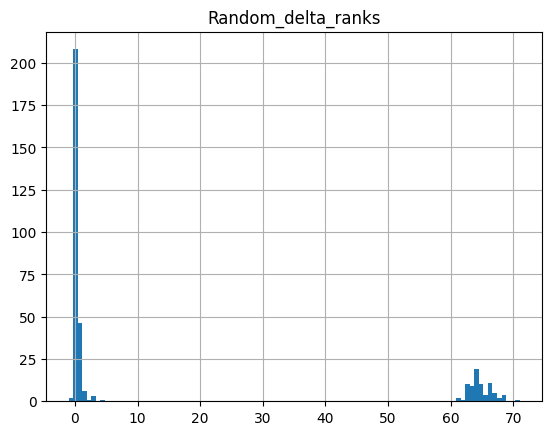

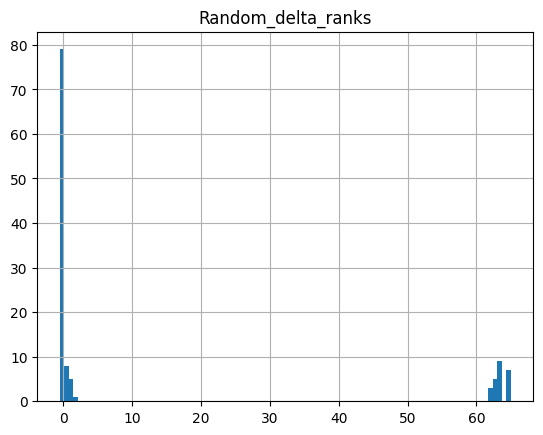

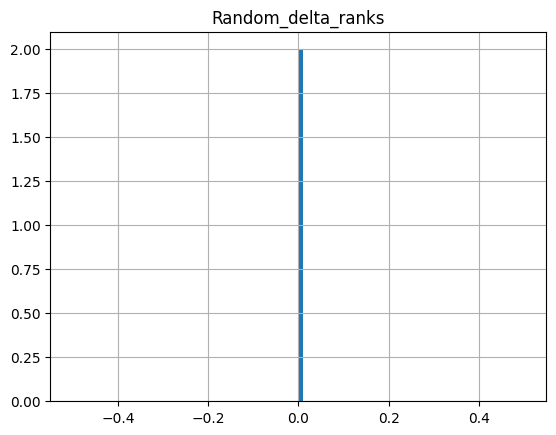

In [91]:
data.groupby('dist_victim_relayer').hist(column='Random_delta_ranks', bins=100)

<Axes: >

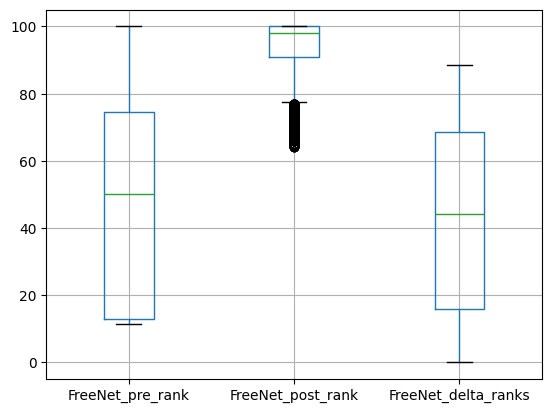

In [ ]:
data[data.dist_victim_relayer>=0].boxplot(column=['FreeNet_pre_rank', 'FreeNet_post_rank', 'FreeNet_delta_ranks'])

<Axes: >

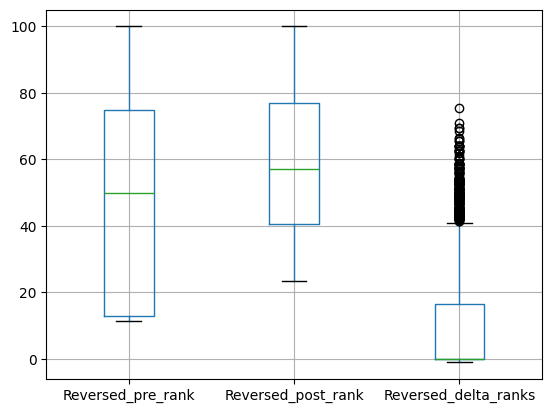

In [9]:
data[data.dist_victim_relayer>=0].boxplot(column=['Reversed_pre_rank', 'Reversed_post_rank', 'Reversed_delta_ranks'])

<Axes: >

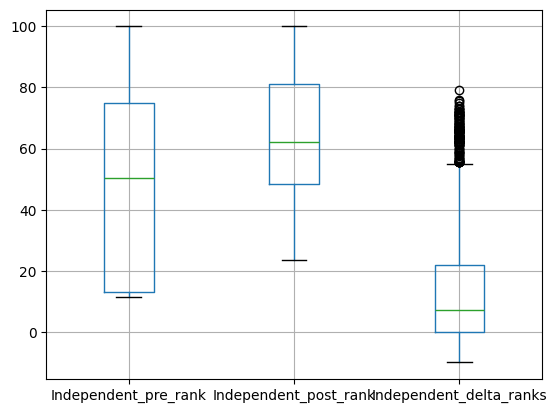

In [10]:
data[data.dist_victim_relayer>=0].boxplot(column=['Independent_pre_rank', 'Independent_post_rank', 'Independent_delta_ranks'])

<Axes: >

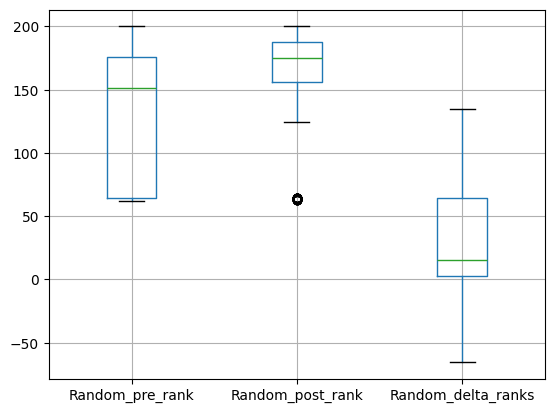

In [11]:
data[data.dist_victim_relayer>=0].boxplot(column=['Random_pre_rank', 'Random_post_rank', 'Random_delta_ranks'])

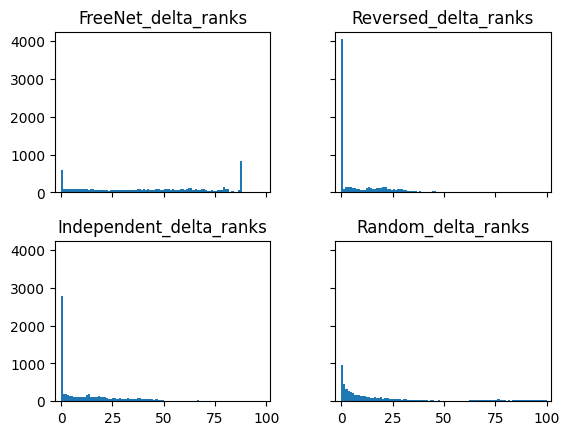

In [116]:
plots = data[data.dist_victim_relayer>=0].hist(column=['FreeNet_delta_ranks', 'Reversed_delta_ranks', 'Independent_delta_ranks', 'Random_delta_ranks'], bins=np.linspace(start=0, stop=100, num=101), grid=False, sharey=True, sharex=True)
for p in plots.flatten():
  p.set_xlim(-3, 102)
# plt.savefig("temp.pdf", bbox_inches="tight")

In [ ]:
np.histogram(
  data[data.dist_victim_relayer>=0]['FreeNet_delta_ranks'],
  bins=np.linspace(start=0, stop=100, num=101)
)

(array([604,  83,  80,  97,  77,  85, 101, 102,  85,  98,  83,  79,  86,
         65,  88,  81,  72,  65,  52,  65,  62,  73,  56,  44,  62,  60,
         61,  55,  57,  72,  68,  66,  72,  61,  61,  53,  71,  80,  82,
         67,  92,  71,  89,  74,  71,  75,  85,  87,  70,  75,  76,  76,
         79,  53,  92,  59,  61,  62,  95,  78,  65,  90, 110, 121,  69,
         78,  63,  51,  94,  98,  71,  40,  39,  67,  48,  49,  72,  75,
         55, 145,  95,  82,  20,  34,   6,   0,  50, 826,  15,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  6

<Axes: xlabel='FreeNet_pre_rank', ylabel='FreeNet_post_rank'>

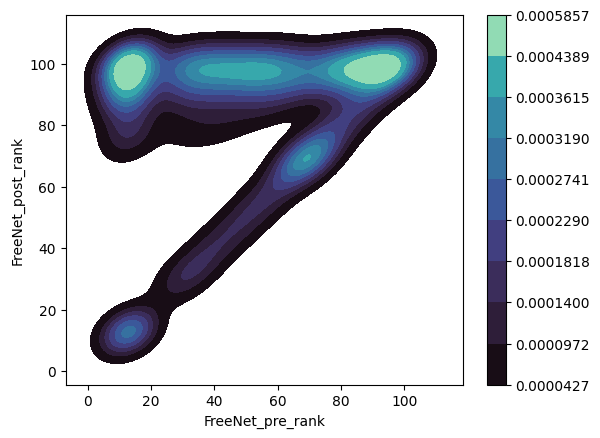

In [12]:
sns.kdeplot(data=data, x="FreeNet_pre_rank", y="FreeNet_post_rank", common_norm=False, fill=True, cmap="mako", cbar=True)

<Axes: xlabel='Reversed_pre_rank', ylabel='Reversed_post_rank'>

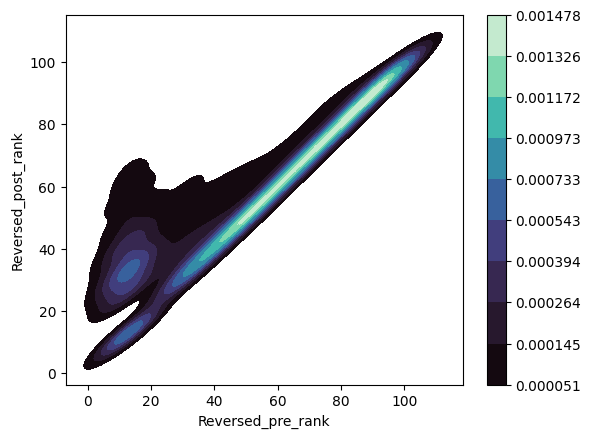

In [13]:
sns.kdeplot(data=data, x="Reversed_pre_rank", y="Reversed_post_rank", common_norm=False, fill=True, cmap="mako", cbar=True)

<Axes: xlabel='Independent_pre_rank', ylabel='Independent_post_rank'>

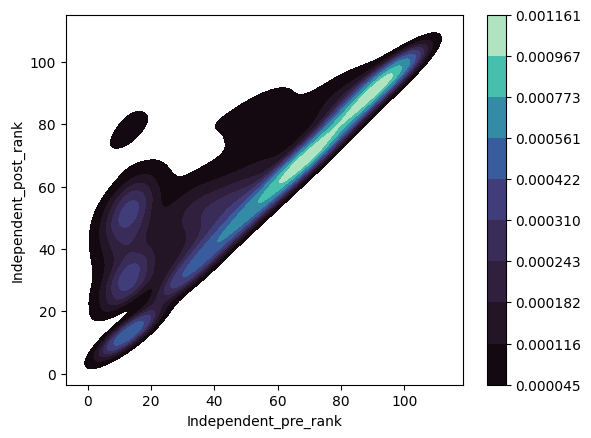

In [14]:
sns.kdeplot(data=data, x="Independent_pre_rank", y="Independent_post_rank", common_norm=False, fill=True, cmap="mako", cbar=True)

In [57]:
def plot_pre_post_rank(data, score):
  mat = np.zeros((100, 100))
  for n, row in data.iterrows():
    mat[int(row[score+'_post_rank'])-1, int(row[score+'_pre_rank'])-1] += 1
  q = np.quantile(mat, 0.99)
  plt.xlabel("Pre rank")
  plt.ylabel("Post rank")
  plt.title(score)
  plt.imshow(mat, cmap="Greys", vmin=0, vmax=q)
  plt.gca().invert_yaxis()
  plt.show()


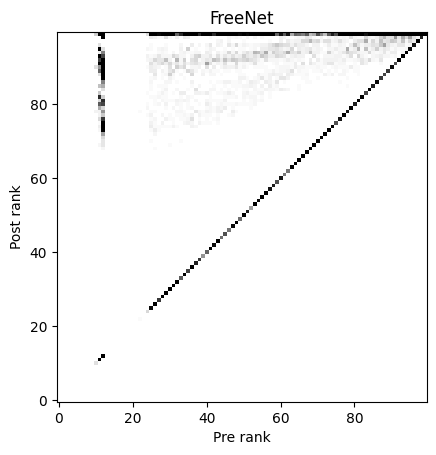

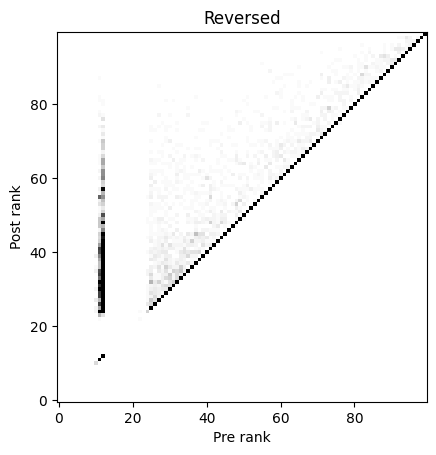

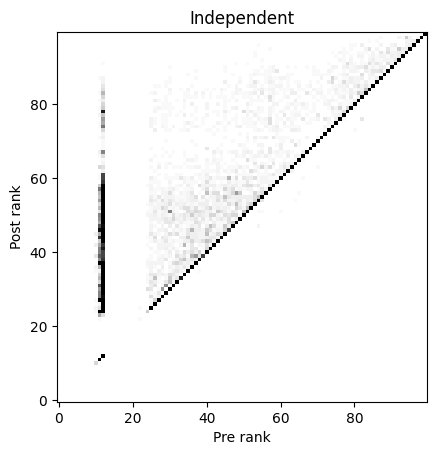

IndexError: index 188 is out of bounds for axis 0 with size 100

In [58]:
plot_pre_post_rank(data, 'FreeNet')
plot_pre_post_rank(data, 'Reversed')
plot_pre_post_rank(data, 'Independent')
plot_pre_post_rank(data, 'Random')

<Axes: xlabel='Random_pre_rank', ylabel='Random_post_rank'>

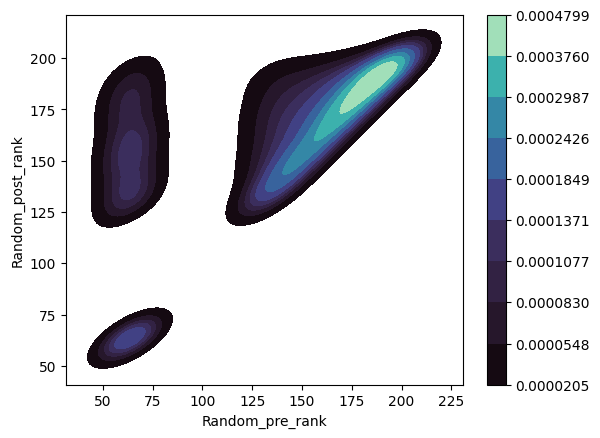

In [15]:
sns.kdeplot(data=data, x="Random_pre_rank", y="Random_post_rank", common_norm=False, fill=True, cmap="mako", cbar=True)

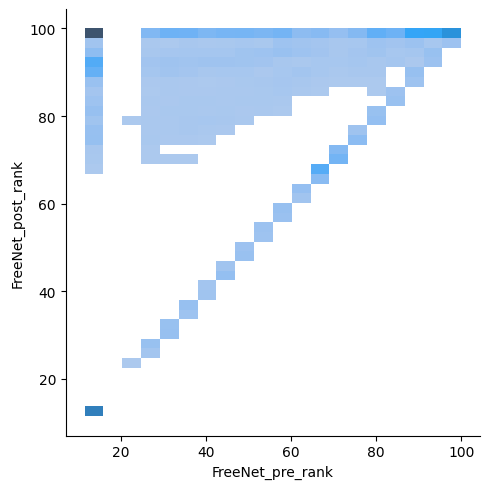

In [60]:
sns.displot(data=data, x="FreeNet_pre_rank", y="FreeNet_post_rank")

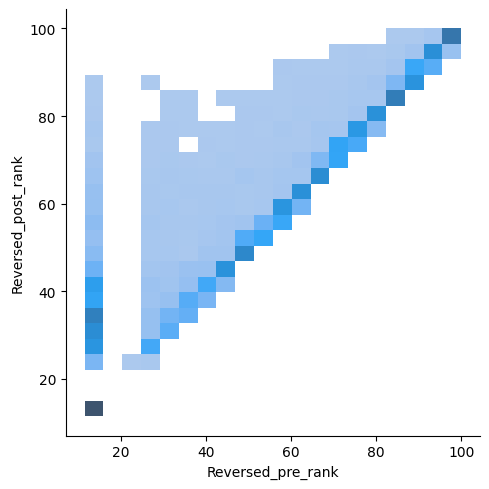

In [17]:
sns.displot(data=data, x="Reversed_pre_rank", y="Reversed_post_rank")

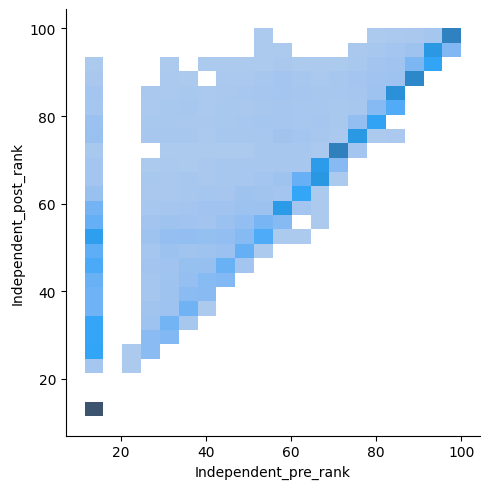

In [18]:
sns.displot(data=data, x="Independent_pre_rank", y="Independent_post_rank")

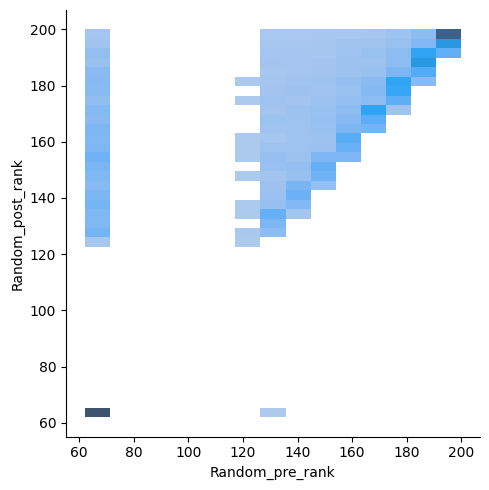

In [19]:
sns.displot(data=data, x="Random_pre_rank", y="Random_post_rank")

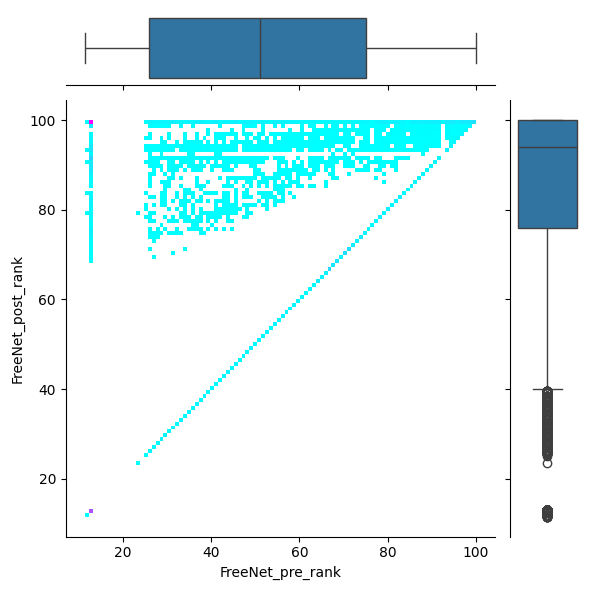

In [87]:
g = sns.JointGrid(data=data, x="FreeNet_pre_rank", y="FreeNet_post_rank")
g.plot_joint(sns.histplot, bins=100, cmap="cool")
g.plot_marginals(sns.boxplot)

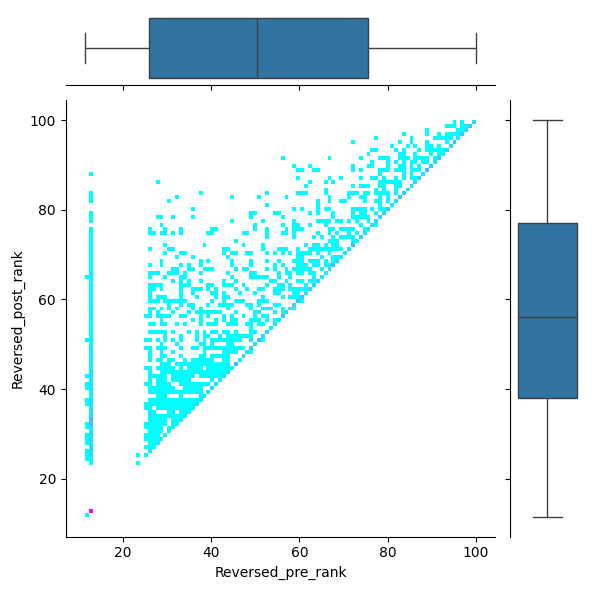

In [77]:
g = sns.JointGrid(data=data, x="Reversed_pre_rank", y="Reversed_post_rank")
g.plot_joint(sns.histplot, bins=100, cmap="cool")
g.plot_marginals(sns.boxplot)

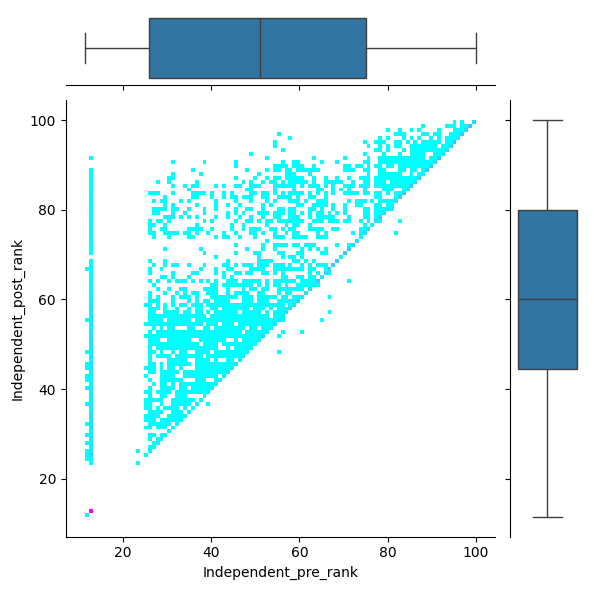

In [78]:
g = sns.JointGrid(data=data, x="Independent_pre_rank", y="Independent_post_rank")
g.plot_joint(sns.histplot, bins=100, cmap="cool")
g.plot_marginals(sns.boxplot)

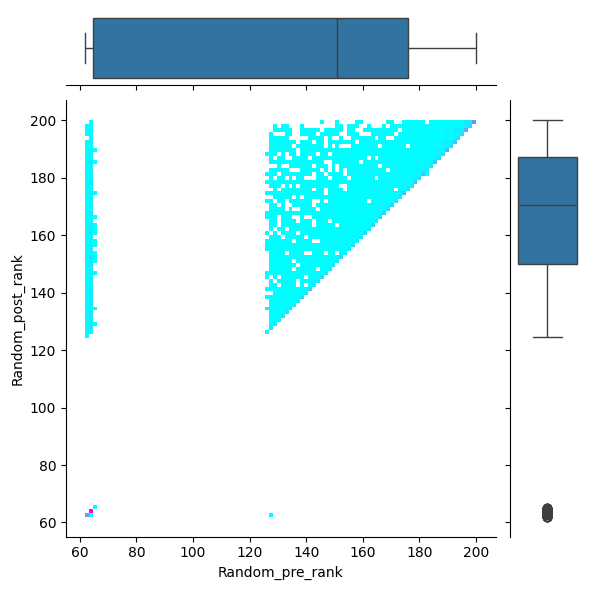

In [80]:
g = sns.JointGrid(data=data, x="Random_pre_rank", y="Random_post_rank")
g.plot_joint(sns.histplot, bins=100, cmap="cool")
g.plot_marginals(sns.boxplot)

In [89]:

def required_length(topK: int, alpha: float) -> int:
    """
    The function required_length() returns the length that the personalized walk
    has to reach for the Personalized Pagerank to achieve the specified precision.
    """
    a = float(alpha)
    c = 100.0
    N = 10000000.0  # Upper bound for the size of the graph.

    res = c / (1 - a) * math.pow(float(topK), a) * math.pow(N, 1 - a)
    return round(res)

print(required_length(5, 0.85))

29379
